# Frequent pattern check

In [24]:
import copy
import pickle
import math
import numpy as np
from tqdm import tqdm
import pandas as pd
from spmf import Spmf
import scipy.cluster.hierarchy as shc





In [2]:
def get_data(file_name):
    return pickle.load(open(file_name, 'rb'))

In [3]:
def get_all_levels(dend):
    branch_depths = [-1]
    branch_depths.extend(list(set([d[1] for d in dend['dcoord']])))
    branch_depths.sort()
    return branch_depths


In [10]:
def get_frequent_patterns(input: list = [], min_sup: float = 0.4, max_gap: int = 1, max_pat_length=""):
    spmf = Spmf("VMSP", input_direct=input,
                input_type="text",
                output_filename="output.txt", spmf_bin_location_dir="/Users/youri/Downloads",
                arguments=[min_sup, max_pat_length, str(max_gap)])
    spmf.run()
    return spmf.to_pandas_dataframe()


Loading data
[INFO] Loading labels
[INFO] Loading distance matrix
[INFO] Loading links
[INFO] Loading stays
[INFO] Loading events
[INFO] Loading clusters
[INFO] Data loaded
[INFO] Calculating dendrogram
[INFO] Dendrogram calculated
[INFO] Sequences ready


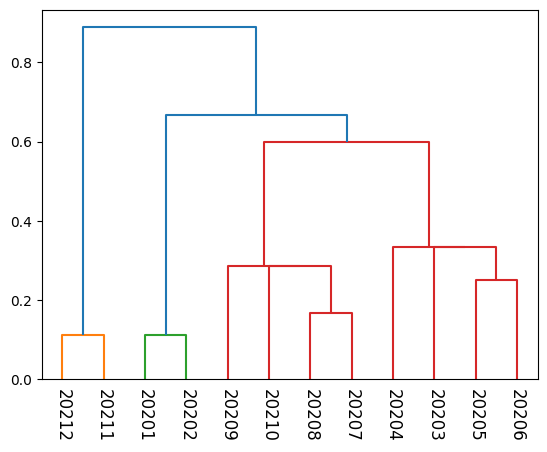

In [4]:
file_suffix = "_test"
# file_suffix = "_1000"



MIN_PATTERN_LENGTH = 2
SEGMENT_SIZE = 4000
# FIRST_PERCENTILE = 2183
FIRST_PERCENTILE = 8000
sequence_to_split_pattern_lookup = []
PATTERN_OUTPUT = f"patterns/pattern-{file_suffix[1:]}/"
# PATTERN_OUTPUT = f"patterns/pattern-10/"

print('Loading data')
print('[INFO] Loading labels')
if 'test' in file_suffix:
    labels = get_data('../scripts/output/labels' + file_suffix)
else:
    labels = get_data('../scripts/output/labels')
print('[INFO] Loading distance matrix')
distances = get_data('../scripts/output/dist_matrix' + file_suffix)
print('[INFO] Loading links')
links = get_data('../scripts/output/links' + file_suffix)
print('[INFO] Loading stays')
stays = get_data('../scripts/output/stays' + file_suffix)
print('[INFO] Loading events')
events = get_data('../scripts/output/events' + file_suffix)
print('[INFO] Loading clusters')
clusters = get_data('../scripts/output/alignments' + file_suffix)
print('[INFO] Data loaded')

print('[INFO] Calculating dendrogram')
dend = shc.dendrogram(links, labels=stays, leaf_rotation=-90)
print('[INFO] Dendrogram calculated')

sequences = []
for stay in stays:
    e = events[events['hadm_id'] == stay]
    sequences.append(''.join(list(e['event_encoded'])))
print('[INFO] Sequences ready')

patterns = pd.DataFrame(columns=['pattern', 'sup', 'encoding'])
levels = get_all_levels(dend)
indices = [dend['ivl'].index(i) for i in stays]


In [5]:

def sort_by_indexes(list_data, indexes, reverse=False):
    return [val for (_, val) in sorted(zip(indexes, list_data), key=lambda x:
            x[0], reverse=reverse)]
    
for i in range(len(clusters)):
    clusters[i] = sort_by_indexes(clusters[i], indices)

stays_original = stays

stays = sort_by_indexes(copy.deepcopy(stays), indices)


In [6]:
def get_closest_cluster_level(level):
    keys = copy.deepcopy(levels)
    keys.pop(-1)

    cluster_level = 0
    level = float(level)

    if level == 1:
        cluster_level = 1.0
    else:
        for clustered_level in keys:
            if (level >= cluster_level and level < clustered_level):
                break
            else:
                cluster_level = clustered_level

    return cluster_level

def find_clustered_events(input_level):
    cluster_level = get_closest_cluster_level(input_level)
    level = levels.index(cluster_level)
    cluster_row = copy.deepcopy(clusters[level])
    alignment_levels = list(dict.fromkeys(cluster_row))

    alignment_data = {}
    for alignment_level in [i for i in alignment_levels if not i == -1]:
        file_param = alignment_level.split("-")
        # alignment_data[alignment_level] = get_data(
        #     f'../scripts/output/stays-10/alignments/alignment-info-10-level-{file_param[0]}-count-{file_param[1]}.p')
        alignment_data[alignment_level] = get_data(
            f'../scripts/output/stays-{file_suffix[1:]}/alignments/alignment-info-{file_suffix[1:]}-level-{file_param[0]}-count-{file_param[1]}.p')
        alignment_data[alignment_level]['aggregated'] = True
        for aligned_sequence in alignment_data[alignment_level]['alignment']:
            aligned_sequence['sequence'] = "".join(
                aligned_sequence['sequence'])

    cluster_data = []
    for index, clust in enumerate(cluster_row):
        if clust == -1:
            # return sequence data
            cluster_data.append({
                'stays': [int(stays[index])],
                'sequence': sequences[index],
                'aggregated': False
            })
        else:
            if not alignment_data[clust] in cluster_data:
                cluster_data.append(alignment_data[clust])

    return cluster_data

In [22]:
def replace_frequent_patterns(c, patterns):
    num_patterns_inserted = 0
    inserted_patterns = []

    seq = replace_gaps_and_to_string(copy.deepcopy(c))

    for index, sequence in tqdm(enumerate(seq)):
        seq_inserted = 0

        s = " " + sequence + " "
        if s[0] != " ":
            s = s.ljust(len(s) + 1, " ")
        if s[-1] != " ":
            s = s.rjust(len(s) + 1, " ")

        for pattern in patterns.itertuples():
            pat = " " + " ".join(pattern.pattern) + " "

            if pat[0] != " ":
                pat = pat.ljust(len(pat) + 1, " ")
            if pat[-1] != " ":
                pat = pat.rjust(len(pat) + 1, " ")

            s_old = s
            s = s.replace(pat, str(pattern.encoding).center(
                len(str(pattern.encoding)) + 2, " "))

            if not s_old == s:
                seq[index] = s

                seq_inserted += 1
                num_patterns_inserted += 1
                inserted_patterns.append(pattern.encoding)

        # print(f"inserted in sequence {index}: {seq_inserted}")

    print(f"number of patterns inserted: {num_patterns_inserted}")

    return seq


def translate_fp_combined_sequences(seq):
    for index, sequence in tqdm(enumerate(seq)):
        if isinstance(sequence, str):
            seq[index] = sequence.strip().split(" ")

            for e_index, event in enumerate(seq[index]):
                if event.isdigit():
                    if patterns.iloc[np.where(patterns.encoding.values == int(event))].aggregated.values[0]:
                        seq[index][e_index] = [int(event)]
                    else:
                        seq[index][e_index] = int(event)
                else:
                    if len(event) > 1:
                        seq[index][e_index] = [e for e in event]
                    else:
                        seq[index][e_index] = event
        else:
            print(f'[ERROR] detected other type: {type(sequence)}')
    return seq

def replace_gaps_and_to_string(c):
    seqs = copy.deepcopy(c)
    for s_index, sequence in enumerate(seqs):
        for e_index, event in enumerate(sequence):
            if isinstance(event, list):
                s_temp = [e if e != "-" else 'x' for e in event]
                s_temp.sort()
                seqs[s_index][e_index] = "".join(s_temp)

        seqs[s_index] = " ".join(seqs[s_index])
    return seqs

def split_long_sequences(sequences):
    segmented_sequences = []

    for s_index, sequence in enumerate(sequences):
        # print(type(sequence))
        # print(sequence[0:100])
        # if len(sequence) > FIRST_PERCENTILE:
        #     for i in range(0, math.ceil(len(sequence) / SEGMENT_SIZE)):
        #         segmented_sequences.append(
        #             sequence[i * SEGMENT_SIZE: (i + 1) * SEGMENT_SIZE - 1])
        #     sequence_to_split_pattern_lookup.append(s_index +
        #                                             math.ceil(len(sequence) / SEGMENT_SIZE) - 1)
        # else:
            segmented_sequences.append(sequence)
            sequence_to_split_pattern_lookup.append(s_index)

        # Transform (segmented) list sequences to (segmented) string sequences
    return replace_gaps_and_to_string(segmented_sequences)


In [8]:
get_all_levels(dend)


[-1,
 0.1111111111111111,
 0.16666666666666666,
 0.25,
 0.2857142857142857,
 0.3333333333333333,
 0.6,
 0.6666666666666666,
 0.8888888888888888]

In [18]:
# level_events = find_clustered_events(-1)
level_events = find_clustered_events(0.16666666666666666)
# level_events = find_clustered_events(0.9958677685950413)
min_sup = 0.2
c = [seq['sequence'] for seq in level_events]
split_sequences = split_long_sequences(copy.deepcopy(c))

# print(split_sequences)

patterns = get_frequent_patterns(
    input=split_sequences, min_sup=min_sup)

print(patterns)


                 pattern  sup
0              [a, b, a]    2
1        [d, b, b, d, d]    2
2  [a, a, a, a, a, a, a]    2
3  [c, c, c, c, c, c, c]    3


In [17]:
pat = patterns[patterns['pattern'].apply(lambda x: len(x) > 1)]
print(pat)
print(len(pat))


Empty DataFrame
Columns: [pattern, sup]
Index: []
0


In [25]:
if len(patterns) > 0:
    patterns = patterns[patterns['pattern'].apply(
        lambda x: len(x) > 1)]
    if (len(patterns) > 0):
        patterns['encoding'] = range(300, len(patterns) + 300)
        patterns['aggregated'] = patterns.apply(lambda row: any(
            len(i.strip()) > 1 for i in row.pattern), axis=1)
        patterns['seq_length'] = patterns.apply(
            lambda row: len(row.pattern), axis=1)
        patterns = patterns.sort_values(
            by=['seq_length', 'sup'], ascending=False)
        patterns = patterns.drop(columns=['seq_length'])

        # seq = sequence_to_list_of_strings([sequence['sequence']
        #                                    for sequence in find_clustered_events(level)])
        seq = replace_frequent_patterns(c, patterns)
        seq = translate_fp_combined_sequences(seq)

        for index, s in enumerate(level_events):
            # s['alignment'] = seq[index]
            s['sequence'] = seq[index]

print(level_events)

9it [00:00, 1915.69it/s]


number of patterns inserted: 9


9it [00:00, 1805.47it/s]

[{'file': 'output/stays-test/alignment-0.1111111111111111-0.fasta', 'stays': [20212, 20211], 'sequence': [300, ['c', 'g'], 'c'], 'alignment': [{'hadm_id': '20212', 'sequence': 'cccccccgc'}, {'hadm_id': '20211', 'sequence': 'ccccccccc'}], 'aggregated': True}, {'file': 'output/stays-test/alignment-0.1111111111111111-1.fasta', 'stays': [20201, 20202], 'sequence': [301, ['a', 'y'], 'a'], 'alignment': [{'hadm_id': '20201', 'sequence': 'aaaaaaaaa'}, {'hadm_id': '20202', 'sequence': 'aaaaaaaya'}], 'aggregated': True}, {'stays': [20209], 'sequence': [302, 'd'], 'aggregated': False}, {'stays': [20210], 'sequence': [303], 'aggregated': False}, {'file': 'output/stays-test/alignment-0.16666666666666666-2.fasta', 'stays': [20208, 20207], 'sequence': [302, ['d', 'x']], 'alignment': [{'hadm_id': '20208', 'sequence': 'dbbdd-'}, {'hadm_id': '20207', 'sequence': 'dbbddd'}], 'aggregated': True}, {'stays': [20204], 'sequence': [300, 'g', 'c'], 'aggregated': False}, {'stays': [20203], 'sequence': [303, 'a'

# Test VGEN vs VMSP

In [282]:
def get_frequent_patterns(input: list = [], min_sup: float = 0.4, max_gap: int = 1, max_pat_length=""):
    spmf = Spmf("VMSP", input_direct=input,
                input_type="text",
                output_filename="output.txt", spmf_bin_location_dir="/Users/youri/Downloads",
                arguments=[min_sup, max_pat_length, str(max_gap)])
    spmf.run()
    return spmf.to_pandas_dataframe()


In [283]:
def get_frequent_patterns(input: list = [], min_sup: float = 0.4, max_gap: int = 1, max_pat_length=""):
    spmf = Spmf("VGEN", input_direct=input,
                input_type="text",
                output_filename="output.txt", spmf_bin_location_dir="/Users/youri/Downloads",
                arguments=[min_sup, max_pat_length, str(max_gap), True])
    spmf.run()
    return spmf.to_pandas_dataframe()

patterns = get_frequent_patterns(
    input=['1 1 1 1', '1 1 2 3 1 ', '1 1 3 1 2', '3 1 2', '2 2 1'], min_sup=0.3)

print(patterns)


     pattern  sup
0         []    5
1        [3]    3
2        [2]    4
3     [1, 1]    3
4     [1, 2]    3
5  [3, 1, 2]    2


In [284]:
def get_frequent_patterns(input: list = [], min_sup: float = 0.4, max_gap: int = 1, max_pat_length=""):
    spmf = Spmf("VMSP", input_direct=input,
                input_type="text",
                output_filename="output.txt", spmf_bin_location_dir="/Users/youri/Downloads",
                arguments=[min_sup, max_pat_length, str(max_gap), True])
    spmf.run()
    return spmf.to_pandas_dataframe()


patterns = get_frequent_patterns(
    input=['1 1 1 1', '1 1 2 3 1 ', '1 1 3 1 2', '3 1 2', '2 2 1'], min_sup=0.3)

print(patterns)


     pattern  sup
0     [1, 1]    3
1  [3, 1, 2]    2


In [285]:
patterns = get_frequent_patterns(
    input=['a a a a', 'a a b', 'a a c'], min_sup=0.4)

print(patterns)


  pattern  sup
0  [a, a]    3


## Check with test set

In [286]:
min_sup_test = 0.5
test_seq = ["a a a a a a a a a",
            "a b b",
            "b b b",
            "d b b d d d",
            "d b b d d",
            "c c c c c c c c c",
            ]


In [287]:
def get_frequent_patterns(input: list = [], min_sup: float = 0.4, max_gap: int = 1, max_pat_length=""):
    spmf = Spmf("VGEN", input_direct=input,
                input_type="text",
                output_filename="output.txt", spmf_bin_location_dir="/Users/youri/Downloads",
                arguments=[min_sup, max_pat_length, str(max_gap), True])
    spmf.run()
    return spmf.to_pandas_dataframe()


patterns = get_frequent_patterns(input=test_seq, min_sup=min_sup_test)

print(patterns)


  pattern  sup
0      []    6
1     [b]    4


In [288]:
def get_frequent_patterns(input: list = [], min_sup: float = 0.4, max_gap: int = 1, max_pat_length=""):
    spmf = Spmf("VMSP", input_direct=input,
                input_type="text",
                output_filename="output.txt", spmf_bin_location_dir="/Users/youri/Downloads",
                arguments=[min_sup, max_pat_length, str(max_gap), True])
    spmf.run()
    return spmf.to_pandas_dataframe()


patterns = get_frequent_patterns(input=test_seq, min_sup=min_sup_test)

print(patterns)


  pattern  sup
0  [b, b]    4
